## DSC 180AB Data Science Capstone
### Replication Project

Team Members: Wenbin Jiang, AJ Falak, and Rongjing Jiang

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

This data gives insights into mental and physical health across different ages. Based on the results, people can better target groups based on their mental/physical health scores. For example, if we find there to be a high correlation between people in a specific age/demographic and their physical health, we can focus efforts on improving health decisions for these groups.
This would allow resource allocation to much more efficient. If we were to accurately predict this it could reduce wait times and help with overall efficiency.For example, healthcare utilization prediction, measuring patients requiring 10 or more medical visits, serves as a vital tool for healthcare systems worldwide, enabling providers to optimize resources regardless of their public or private framework. 



In a dataset like this, errors can have a huge real-world impact, especially in terms of resource utilization. As mentioned earlier, if we conclude that specific groups need more resources/help but find out that there were errors in the data/algorithm, then we would be incorrectly using resources that could be helping demographics that need it more.
The affected parties and stakeholders would include anyone from the healthcare sector. This would include patients, healthcare providers, insurance companies, and policymakers. For instance, patients and healthcare providers may depend on the model for identification and health assessments. It is crucial that the predictions it makes are accurate and precise.


---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [6]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline


In [15]:
raw_181 = pd.read_csv('h181.csv')

#### Apply pre-processing scripts

In [16]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [17]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [18]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [19]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [20]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [21]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

First thing is we want to check the dimensions of the dataset

In [22]:
print(df_panel_19_reduced.shape)

(15830, 43)


Also we want to view the column names

In [23]:
print(df_panel_19_reduced.columns)

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F'],
      dtype='object')


Get an overview of the dataset - top five

In [24]:
df_panel_19_reduced.head()

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,Non-White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,Non-White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,Non-White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,Non-White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,None,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000


Get an overview of the dataset - bottom five

In [25]:
df_panel_19_reduced.tail()

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16573,3,25,1,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,None,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005
16577,1,73,2,None,2,-1,4,2,2,1,...,2,42.68,43.46,0,0,4,3,2,0,6630.588948


We can view the summary statistics of numerical columns with df.describe() method. It enable us to detect outliers in the data which require further investigation.

In [26]:
df_panel_19_reduced.dtypes

df_panel_19_reduced.describe()


,REGION,AGE,SEX,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,HIBPDX,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
count,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,...,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000
mean,2.825584,35.090461,1.521162,3.661213,-0.720088,2.581364,2.224889,2.187871,1.993051,0.918067,...,0.726153,29.358455,30.851517,1.274289,-0.003853,1.375426,3.298547,1.585344,0.171699,8930.337369
std,1.002033,22.475549,0.499568,2.121255,0.910025,0.758747,0.512242,1.054677,1.002657,1.267763,...,1.419339,25.996522,26.968146,3.955331,1.278136,1.854929,1.476351,0.688718,0.377131,8521.260446
min,1.000000,0.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-9.000000,-9.000000,-9.000000,-1.000000,-1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,15.000000,1.000000,1.000000,-1.000000,2.000000,2.000000,1.000000,1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,1.000000,0.000000,3428.548713
50%,3.000000,33.000000,2.000000,5.000000,-1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,...,2.000000,39.505000,42.480000,0.000000,0.000000,1.000000,4.000000,1.000000,0.000000,6146.458935
75%,4.000000,53.000000,2.000000,6.000000,-1.000000,3.000000,3.000000,3.000000,3.000000,2.000000,...,2.000000,54.800000,56.580000,2.000000,0.000000,4.000000,5.000000,2.000000,0.000000,11749.810086
max,4.000000,85.000000,2.000000,10.000000,3.000000,4.000000,4.000000,5.000000,5.000000,2.000000,...,2.000000,72.070000,75.510000,24.000000,6.000000,4.000000,5.000000,3.000000,1.000000,94264.071559


**Looking at this data, here are the key conclusions we can draw:**

1. Demographics:
    - The average age is around 35 years, with a wide spread (std dev ≈ 22.5 years), suggesting a diverse age range
    - There's a slightly higher proportion of one gender over another (mean of 1.52 for SEX, suggesting roughly 52% are coded as "2")
    - People are spread across 4 regions, with a slight skew toward certain regions (mean 2.83)


2. Marital Status:
    - The MARRY variable shows significant variation (mean 3.66, std dev 2.12)
    - The range is 1-10, suggesting multiple categories for relationship status
    - Most people fall in the lower categories (median = 5.0)

The marital status is kinda to grab our eyes so I want to dig more into this sepcify category.

Here I have the data preparation step in analysis pipelines, making the data more structured and easier to analyze for age-related trends and patterns.

First, it replaces all -1 values with NaN (Not a Number) to properly handle missing data, making it easier for statistical analysis and data manipulation. Second, it creates a new column 'AGE_GROUP' that categorizes ages into five meaningful groups (0-18, 19-35, 36-50, 51-65, 65+), which transforms the continuous age variable into categorical groups for better demographic analysis and trend identification.

In [31]:
# Replace -1 with NaN as it appears to be a missing value indicator
df_panel_19_reduced = df_panel_19_reduced.replace(-1, np.nan)
    
# Create age groups for better analysis
df_panel_19_reduced['AGE_GROUP'] = pd.cut(df_panel_19_reduced['AGE'], 
                            bins=[0, 18, 35, 50, 65, 100],
                            labels=['0-18', '19-35', '36-50', '51-65', '65+'])

df_panel_19_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F,AGE_GROUP
0,2,53,1,Non-White,5,NaN,2,2,4.0,3.0,...,25.93,58.47,3.0,0.0,4.0,1,2,1,21854.981705,51-65
1,2,56,2,Non-White,3,NaN,2,2,4.0,3.0,...,20.42,26.57,17.0,6.0,4.0,3,2,1,18169.604822,51-65
3,2,23,2,Non-White,5,3.0,2,2,1.0,1.0,...,53.12,50.33,7.0,0.0,1.0,2,2,0,17191.832515,19-35
4,2,3,1,Non-White,6,NaN,3,3,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,2,2,0,20261.485463,0-18
5,3,27,1,None,1,NaN,1,4,2.0,1.0,...,NaN,NaN,NaN,NaN,1.0,3,1,0,0.000000,19-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,None,1,NaN,2,2,1.0,1.0,...,56.71,62.39,0.0,0.0,1.0,1,1,0,4111.315754,19-35
16574,3,25,2,None,1,NaN,2,2,1.0,1.0,...,56.71,62.39,0.0,0.0,4.0,1,1,0,5415.228173,19-35
16575,3,2,2,Non-White,6,NaN,3,3,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1,2,0,3896.116219,0-18
16576,1,54,2,None,3,NaN,2,2,1.0,1.0,...,43.97,42.45,24.0,0.0,1.0,3,2,0,4883.851005,51-65


Through these four graphs, we can see some interesting patterns in our population. 

The age distribution shows that we have participants across all age groups, with a larger concentration of people between 20-60 years old, and fewer participants in the very young and elderly categories. In terms of gender balance, the population is almost evenly split, with slightly more females (52.1%) than males (47.9%).


The race data shows that all participants in this survey were classified as 'Non-White', which suggests this might be a focused study on a specific demographic group. This could also mean that Non-White was the only Non-Null race that was inputted. We will explore this further below. 

As for marriage status, we can see that categories 1, 5, and 6 are the most common in our dataset. Specifically, category 1 typically represents 'Married' individuals, category 5 refers to those who are 'Widowed', and category 6 denotes respondents under the age of 16, for whom marital status is deemed 'Inapplicable'. These categories help us understand the various relationship statuses within the surveyed population. 

These demographics suggest we're looking at a diverse adult population in terms of age and gender, but with specific racial characteristics, which should be considered when interpreting any broader findings from this survey

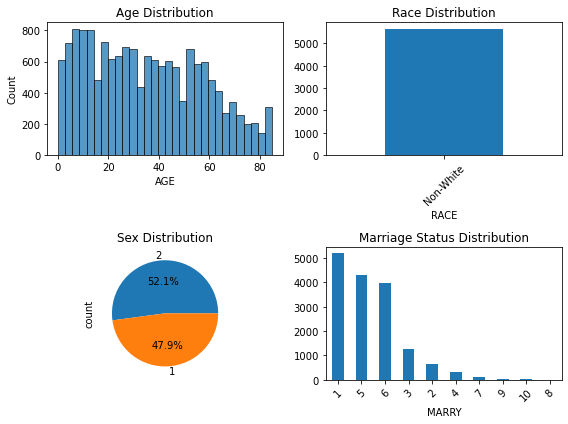

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_demographic_distributions(df):
    """
    Create demographic distribution plots
    """
    # Create a figure with 2x2 subplots, adjusting figsize for better layout
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    
    # Age distribution
    sns.histplot(data=df, x='AGE', bins=30, ax=axs[0, 0])
    axs[0, 0].set_title('Age Distribution')
    
    # Race distribution
    df['RACE'].value_counts().plot(kind='bar', ax=axs[0, 1])
    axs[0, 1].set_title('Race Distribution')
    axs[0, 1].tick_params(axis='x', rotation=45)
    
    # Sex distribution
    df['SEX'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1, 0])
    axs[1, 0].set_title('Sex Distribution')
    
    # Marriage status
    df['MARRY'].value_counts().plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title('Marriage Status Distribution')
    axs[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the plot
    plt.close(fig)  # Close the figure after displaying

plot_demographic_distributions(df_panel_19_reduced)

#### 2.3 Outlier Detection and Handling

**Next step we need to check is there any outlier and how do we handlie it.**

**Why outliers matter?**
- They can skew our analysis and lead to incorrect conclusions
- Some outliers might be data entry errors that need correction
- Others might be legitimate but rare cases we need to understand better

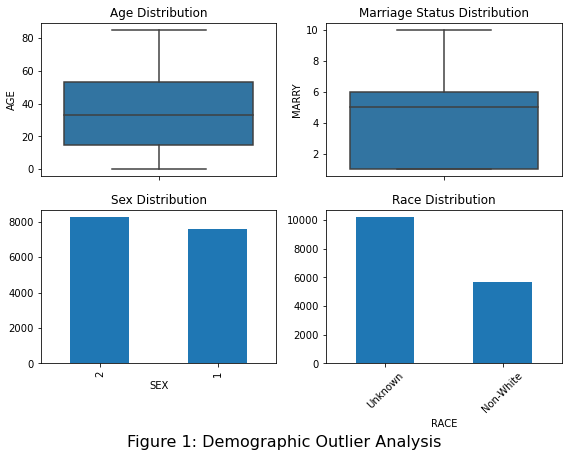

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_demographic_outliers(df, fig_num=1):
    """
    Analyze outliers specifically for demographic variables: age, race, sex, and marriage
    """
    # Select only demographic columns and handle NaN values
    demographic_cols = ['AGE', 'RACE', 'SEX', 'MARRY']
    demo_data = df[demographic_cols].copy()
    
    # Fill NaN values with appropriate values for each column
    demo_data['AGE'] = demo_data['AGE'].fillna(demo_data['AGE'].median())
    demo_data['RACE'] = demo_data['RACE'].fillna('Unknown')
    demo_data['SEX'] = demo_data['SEX'].fillna(demo_data['SEX'].mode()[0])
    demo_data['MARRY'] = demo_data['MARRY'].fillna(demo_data['MARRY'].mode()[0])
    
    # Create figure for analysis
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    fig.supxlabel(f'Figure {fig_num}: Demographic Outlier Analysis', fontsize=16, y=-0.05)  # Add figure title at the bottom
    
    # Box plots for numerical variables only (AGE and MARRY)
    sns.boxplot(y=demo_data['AGE'], ax=axes[0, 0])
    axes[0, 0].set_title('Age Distribution')
    
    sns.boxplot(y=demo_data['MARRY'], ax=axes[0, 1])
    axes[0, 1].set_title('Marriage Status Distribution')
    
    # Bar plots for categorical variables (SEX and RACE)
    demo_data['SEX'].value_counts().plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Sex Distribution')
    
    demo_data['RACE'].value_counts().plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Race Distribution')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    plt.close(fig)
    
    # Calculate outliers for numerical variables only
    outliers_summary = {}
    for col in ['AGE', 'MARRY']:  # Only analyze numerical columns
        Q1 = demo_data[col].quantile(0.25)
        Q3 = demo_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = demo_data[(demo_data[col] < lower_bound) | (demo_data[col] > upper_bound)][col]
        outliers_summary[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(demo_data)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min': demo_data[col].min(),
            'max': demo_data[col].max()
        }
    
    return outliers_summary, demo_data

# Run the analysis and assign the figure number
outliers_summary, demo_data = analyze_demographic_outliers(df_panel_19_reduced, fig_num=1)


**Understanding Our Community Demographics (figure 1): Key Findings**

1. Age Patterns
- Most people in our community are middle-age adults
- The typical age is around 30-35 years old
- We have a good mix of younger and older adults, ranging mainly from early 20s to mid-50s
- This could also be a reason why majority of the marriage status is married, widowed, and inapplicable. 

**This suggests we're looking at a primarily working-age population**


2. Gender Balance
- Our community shows a fairly even split between men (1) and women (2)
- There's a slightly higher number of one gender, but the difference is small

**This balanced representation helps us understand both perspectives fairly.**


3. Relationship Status
- We see a diverse mix of relationship statuses in our community
- This variety reflects different life stages and personal choices
- 

**The distribution suggests we're capturing a good range of family situations.**

4. Cultural Diversity
- About 5,500-6,000 individuals are identified as Non-White
- We note that most demographic information is "Unknown," so right now, its hard to come up with a conclusion about the diversity of the community in right now


----------------------------------------------------------------------------------------------
Next step: Comparing Before and After Outlier Removal

In [50]:
# Handle outliers and add figure labels to comparison plots (Age & Marriage stastus)
def plot_comparison_before_after(demo_data, df_cleaned, fig_num=2):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    fig.supxlabel(f'Figure {fig_num}: Comparison of Distributions Before and After Cleaning', fontsize=14, y=-0.05)
    
    # Before cleaning
    sns.boxplot(y=demo_data['AGE'], ax=axes[0, 0])
    axes[0, 0].set_title('Age Before Cleaning')
    
    sns.boxplot(y=demo_data['MARRY'], ax=axes[0, 1])
    axes[0, 1].set_title('Marriage Status Before Cleaning')
    
    # After cleaning
    sns.boxplot(y=df_cleaned['AGE'], ax=axes[1, 0])
    axes[1, 0].set_title('Age After Cleaning')
    
    sns.boxplot(y=df_cleaned['MARRY'], ax=axes[1, 1])
    axes[1, 1].set_title('Marriage Status After Cleaning')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Adjust layout to make space for the suptitle
    plt.show()
    plt.close(fig)

# Run the comparison plot
plot_comparison_before_after(demo_data, df_cleaned, fig_num=2)

NameError: name 'df_cleaned' is not defined

Draw the conclustion (Age & Marriage Status):
- The overall shape of the distribution remains very similar after outlier removal
- This suggests that the outliers weren't severely impacting the central tendency of your data
- The whiskers (vertical lines extending from the box) appear slightly more symmetrical in the cleaned data

In [51]:
# Handle outliers and add figure labels to comparison plots (Sex & Race)
def plot_comparison_before_after(demo_data, df_cleaned, fig_num=2):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    fig.supxlabel(f'Figure {fig_num}: Comparison of Distributions Before and After Cleaning', fontsize=14, y=-0.05)
    
    # Before cleaning
    demo_data['SEX'].value_counts().plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Sex Before Cleaning')
    
    demo_data['RACE'].value_counts().plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Race Before Cleaning')
    
    # After cleaning
    df_cleaned['SEX'].value_counts().plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Sex After Cleaning')
    
    df_cleaned['RACE'].value_counts().plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Race After Cleaning')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Adjust layout to make space for the figure label
    plt.show()
    plt.close(fig)

# Run the comparison plot
plot_comparison_before_after(demo_data, df_cleaned, fig_num=3)


NameError: name 'df_cleaned' is not defined

Data Reliability:
- Our careful data cleaning process shows that our original demographic information was already quite reliable. The patterns we see in both gender and race stayed almost the same before and after cleaning, which gives us confidence in our initial data collection.

Gender Balance:
- We maintain a good balance between our gender categories, with only slight differences between the groups. This balanced representation remained stable through our cleaning process.

Racial Demographics:
- While we still have a large number of 'Unknown' entries in our race category, this appears to be a genuine characteristic of our data rather than a data quality issue. The consistent numbers before and after cleaning suggest this is a true reflection of our available information.

---------------------------

Next step
- Consider improving initial data collection for race demographics to reduce 'Unknown' entries

Initial Analysis:
Total records: 15,830
Unknown race entries: 0 (0.0%)


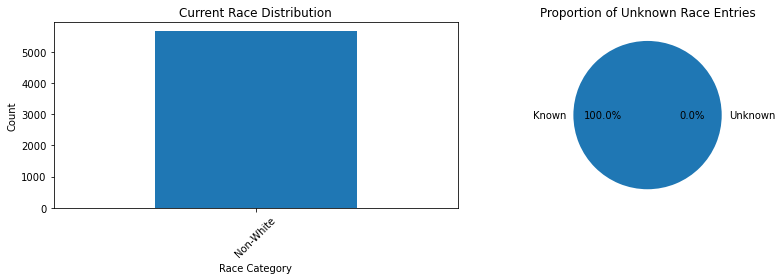


Recommended Improvements:

Data Collection Improvements:
  1. Update data collection forms to include clear race categories
  2. Make race field mandatory during data entry
  3. Add 'Prefer not to say' option instead of leaving blank
  4. Implement dropdown menu instead of free-text entry

Data Quality Checks:
  1. Regular audits of new entries
  2. Follow-up process for Unknown entries
  3. Staff training on proper data collection
  4. Monthly data quality reports

Proposed Race Categories:
  White
  Black or African American
  Asian
  Hispanic or Latino
  Native American
  Pacific Islander
  Multiple Races
  Other
  Prefer not to say

Data Cleaning Results:
Before cleaning:
RACE
Non-White    5656
Name: count, dtype: int64

After cleaning:
RACE
Unknown      10174
Non-White     5656
Name: count, dtype: int64


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_unknown_race(df):
    """
    Analyze and handle Unknown race entries in the dataset
    """
    # Calculate initial statistics
    total_records = len(df)
    unknown_count = len(df[df['RACE'] == 'Unknown'])
    unknown_percentage = (unknown_count / total_records) * 100
    
    print(f"Initial Analysis:")
    print(f"Total records: {total_records:,}")
    print(f"Unknown race entries: {unknown_count:,} ({unknown_percentage:.1f}%)")
    
    # Visualize Unknown vs Non-Unknown distribution
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Current Race Distribution
    plt.subplot(1, 2, 1)
    df['RACE'].value_counts().plot(kind='bar')
    plt.title('Current Race Distribution')
    plt.xlabel('Race Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot 2: Unknown vs Known Proportion
    plt.subplot(1, 2, 2)
    labels = ['Known', 'Unknown']
    sizes = [(total_records - unknown_count), unknown_count]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('Proportion of Unknown Race Entries')
    
    plt.tight_layout()
    plt.show()
    
    return total_records, unknown_count, unknown_percentage

def suggest_race_improvements(df):
    """
    Generate specific suggestions for reducing Unknown race entries
    """
    suggestions = {
        "Data Collection Improvements": [
            "1. Update data collection forms to include clear race categories",
            "2. Make race field mandatory during data entry",
            "3. Add 'Prefer not to say' option instead of leaving blank",
            "4. Implement dropdown menu instead of free-text entry"
        ],
        "Data Quality Checks": [
            "1. Regular audits of new entries",
            "2. Follow-up process for Unknown entries",
            "3. Staff training on proper data collection",
            "4. Monthly data quality reports"
        ],
        "Proposed Race Categories": [
            "White",
            "Black or African American",
            "Asian",
            "Hispanic or Latino",
            "Native American",
            "Pacific Islander",
            "Multiple Races",
            "Other",
            "Prefer not to say"
        ]
    }
    
    return suggestions

def implement_race_validation(df):
    """
    Implement basic validation and cleaning for race field
    """
    # Create a copy to avoid modifying original data
    df_cleaned = df.copy()
    
    # Define standard race categories
    standard_categories = {
        'unknown': 'Unknown',
        'non-white': 'Non-White',
        'white': 'White',
        'black': 'Non-White',
        'asian': 'Non-White',
        'hispanic': 'Non-White',
        'latino': 'Non-White',
        'native': 'Non-White',
        'pacific': 'Non-White'
    }
    
    # Clean existing race entries
    df_cleaned['RACE'] = df_cleaned['RACE'].str.lower()
    df_cleaned['RACE'] = df_cleaned['RACE'].map(standard_categories).fillna('Unknown')
    
    # Compare before and after
    print("\nData Cleaning Results:")
    print("Before cleaning:")
    print(df['RACE'].value_counts())
    print("\nAfter cleaning:")
    print(df_cleaned['RACE'].value_counts())
    
    return df_cleaned

# Run the analysis
total_records, unknown_count, unknown_percentage = analyze_unknown_race(df_panel_19_reduced)

# Get improvement suggestions
suggestions = suggest_race_improvements(df_panel_19_reduced)

# Print suggestions
print("\nRecommended Improvements:")
for category, items in suggestions.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  {item}")

# Clean the data
df_race_cleaned = implement_race_validation(df_panel_19_reduced)

Since 'RACE' is categorical data so we need to use One-hot encoding that ensures models interpret it correctly without assuming order or hierarchy among categories.

In [53]:
# One-hot encode the 'RACE' column
df_race_encoded = pd.get_dummies(df_race_cleaned, columns=['RACE'], prefix='RACE')

# Convert only the one-hot encoded columns to integers
race_columns = [col for col in df_race_encoded.columns if col.startswith('RACE_')]
df_race_encoded[race_columns] = df_race_encoded[race_columns].astype(int)

# Display the first few rows to check the result
print(df_race_encoded.head())



   REGION  AGE  SEX  MARRY  FTSTU  ACTDTY  HONRDC  RTHLTH  MNHLTH  HIBPDX  \
0       2   53    1      5    NaN       2       2     4.0     3.0     1.0   
1       2   56    2      3    NaN       2       2     4.0     3.0     1.0   
3       2   23    2      5    3.0       2       2     1.0     1.0     2.0   
4       2    3    1      6    NaN       3       3     1.0     3.0     NaN   
5       3   27    1      1    NaN       1       4     2.0     1.0     2.0   

   ...  K6SUM42  PHQ242  EMPST  POVCAT  INSCOV  UTILIZATION      PERWT15F  \
0  ...      3.0     0.0    4.0       1       2            1  21854.981705   
1  ...     17.0     6.0    4.0       3       2            1  18169.604822   
3  ...      7.0     0.0    1.0       2       2            0  17191.832515   
4  ...      NaN     NaN    NaN       2       2            0  20261.485463   
5  ...      NaN     NaN    1.0       3       1            0      0.000000   

   AGE_GROUP  RACE_Non-White  RACE_Unknown  
0      46-55               1 

Now let's talk ab

In [64]:
df_race_cleaned.columns

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F', 'AGE_GROUP'],
      dtype='object')

In [62]:
df_race_cleaned['UTILIZATION'].value_counts()

UTILIZATION
0    13112
1     2718
Name: count, dtype: int64

#### 2.4 Correlation Analysis
---------------------------------

!!! BELOW NEED TO RE-CHECK AND MAKE IT MORE EXPLAINABLE

,AGE,SEX,UTILIZATION,RACE_Non-White,MARRY_1,MARRY_2,MARRY_3,MARRY_4,MARRY_5,MARRY_6,MARRY_7,MARRY_8,MARRY_9,MARRY_10
AGE,1.000000,0.057985,0.337893,0.182119,0.459116,0.348961,0.244673,0.087169,-0.135137,-0.702489,0.005646,0.024903,0.012054,0.008966
SEX,0.057985,1.000000,0.099081,-0.017336,-0.030559,0.119124,0.055527,0.035842,-0.017488,-0.048736,-0.008230,0.012168,0.000193,0.000193
UTILIZATION,0.337893,0.099081,1.000000,0.165296,0.102975,0.171158,0.094985,0.010159,-0.072104,-0.176390,-0.006162,-0.008866,0.006417,-0.011992
RACE_Non-White,0.182119,-0.017336,0.165296,1.000000,0.154434,0.061058,0.054544,-0.054510,-0.099196,-0.110525,0.003692,0.005799,0.001799,-0.005444
MARRY_1,0.459116,-0.030559,0.102975,0.154434,1.000000,-0.144899,-0.204881,-0.099131,-0.427009,-0.404892,-0.053452,-0.013613,-0.025480,-0.025480
MARRY_2,0.348961,0.119124,0.171158,0.061058,-0.144899,1.000000,-0.060739,-0.029388,-0.126592,-0.120035,-0.015847,-0.004036,-0.007554,-0.007554
MARRY_3,0.244673,0.055527,0.094985,0.054544,-0.204881,-0.060739,1.000000,-0.041554,-0.178995,-0.169724,-0.022406,-0.005707,-0.010681,-0.010681
MARRY_4,0.087169,0.035842,0.010159,-0.054510,-0.099131,-0.029388,-0.041554,1.000000,-0.086606,-0.082120,-0.010841,-0.002761,-0.005168,-0.005168
MARRY_5,-0.135137,-0.017488,-0.072104,-0.099196,-0.427009,-0.126592,-0.178995,-0.086606,1.000000,-0.353736,-0.046699,-0.011893,-0.022261,-0.022261
MARRY_6,-0.702489,-0.048736,-0.176390,-0.110525,-0.404892,-0.120035,-0.169724,-0.082120,-0.353736,1.000000,-0.044280,-0.011277,-0.021108,-0.021108


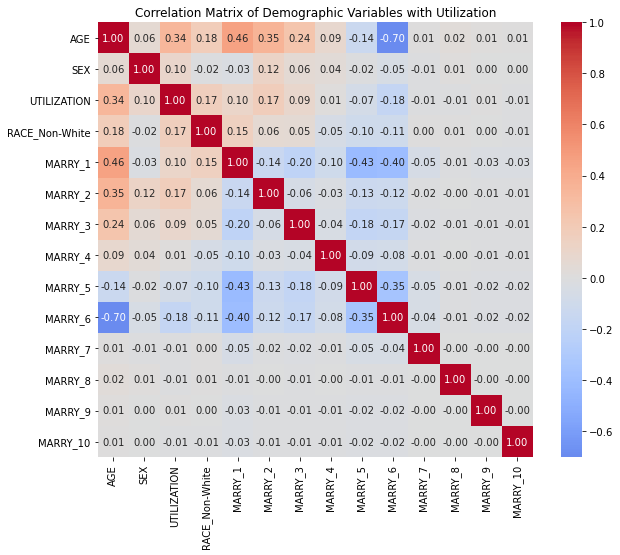

In [54]:
def correlation_analysis(df):
    """
    Analyze correlations between specific demographic variables:
    AGE, SEX, RACE, MARRY with UTILIZATION
    """
    # Create a copy of the dataframe with only the variables we want
    selected_cols = ['AGE', 'SEX', 'RACE', 'MARRY', 'UTILIZATION']
    df_selected = df[selected_cols].copy()
    
    # Convert categorical variables to numeric if they aren't already
    # Create dummy variables for categorical columns
    df_encoded = pd.get_dummies(df_selected, columns=['RACE', 'MARRY'])
    
    # Keep SEX as is since it's likely already numeric (1/2)
    
    # Calculate correlation matrix
    correlation_matrix = df_encoded.corr()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True)
    plt.title('Correlation Matrix of Demographic Variables with Utilization')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # Return both the plot and the correlation matrix
    return correlation_matrix


correlation_analysis(df_panel_19_reduced)

In [55]:
def analyze_marry_categories(df):
    """
    Analyze MARRY categories distribution and relationships
    """
    # Get value counts of original MARRY column
    marry_dist = df['MARRY'].value_counts().sort_index()
    
    print("MARRY Categories Distribution:")
    print("-----------------------------")
    for category, count in marry_dist.items():
        percentage = (count/len(df))*100
        print(f"MARRY_{category}: {count} records ({percentage:.1f}%)")
        
    # Look at average utilization by MARRY category
    avg_util = df.groupby('MARRY')['UTILIZATION'].agg(['mean', 'count'])
    print("\nAverage Utilization by MARRY Category:")
    print("------------------------------------")
    print(avg_util)

analyze_marry_categories(df_panel_19_reduced)

MARRY Categories Distribution:
-----------------------------
MARRY_1: 5197 records (32.8%)
MARRY_2: 652 records (4.1%)
MARRY_3: 1252 records (7.9%)
MARRY_4: 312 records (2.0%)
MARRY_5: 4301 records (27.2%)
MARRY_6: 3976 records (25.1%)
MARRY_7: 92 records (0.6%)
MARRY_8: 6 records (0.0%)
MARRY_9: 21 records (0.1%)
MARRY_10: 21 records (0.1%)

Average Utilization by MARRY Category:
------------------------------------
           mean  count
MARRY                 
1      0.227246   5197
2      0.483129    652
3      0.293930   1252
4      0.198718    312
5      0.127180   4301
6      0.056841   3976
7      0.141304     92
8      0.000000      6
9      0.238095     21
10     0.047619     21


,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F,AGE_GROUP,MARRY_STATUS
0,2,53,1,Non-White,5,NaN,2,2,4.0,3.0,...,58.47,3.0,0.0,4.0,1,2,1,21854.981705,46-55,Never Married
1,2,56,2,Non-White,3,NaN,2,2,4.0,3.0,...,26.57,17.0,6.0,4.0,3,2,1,18169.604822,56-65,Divorced
3,2,23,2,Non-White,5,3.0,2,2,1.0,1.0,...,50.33,7.0,0.0,1.0,2,2,0,17191.832515,18-25,Never Married
4,2,3,1,Non-White,6,NaN,3,3,1.0,3.0,...,NaN,NaN,NaN,NaN,2,2,0,20261.485463,18-25,Under 16
5,3,27,1,None,1,NaN,1,4,2.0,1.0,...,NaN,NaN,NaN,1.0,3,1,0,0.000000,26-35,Married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,None,1,NaN,2,2,1.0,1.0,...,62.39,0.0,0.0,1.0,1,1,0,4111.315754,18-25,Married
16574,3,25,2,None,1,NaN,2,2,1.0,1.0,...,62.39,0.0,0.0,4.0,1,1,0,5415.228173,18-25,Married
16575,3,2,2,Non-White,6,NaN,3,3,1.0,1.0,...,NaN,NaN,NaN,NaN,1,2,0,3896.116219,18-25,Under 16
16576,1,54,2,None,3,NaN,2,2,1.0,1.0,...,42.45,24.0,0.0,1.0,3,2,0,4883.851005,46-55,Divorced


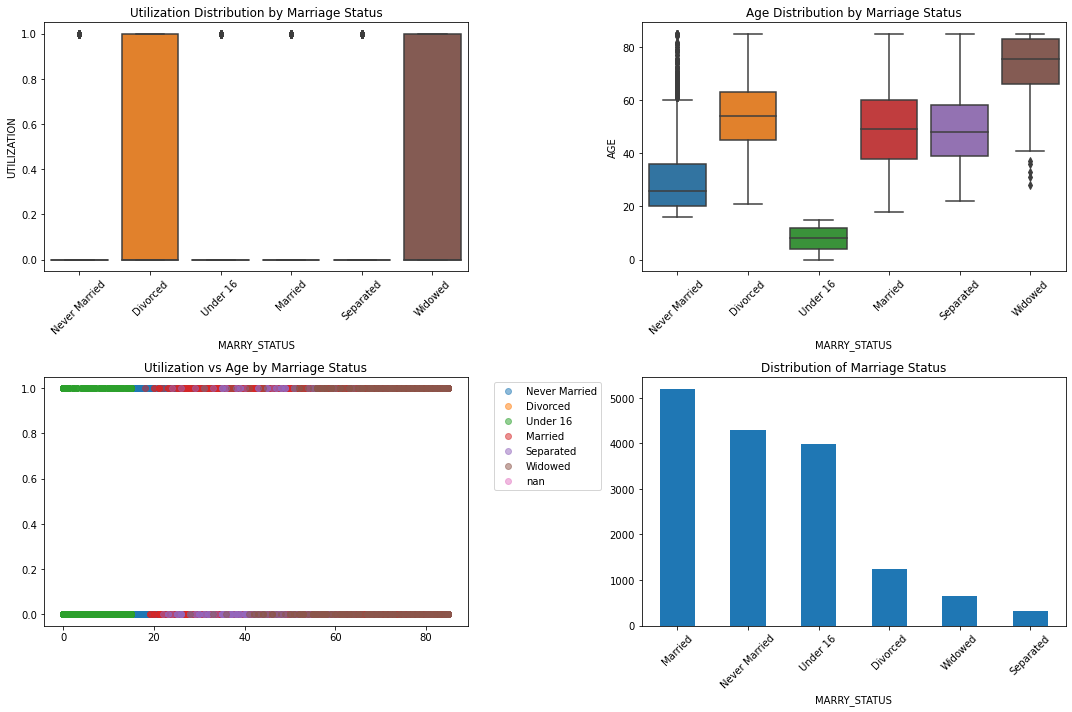

In [65]:
def simplified_marry_analysis(df):
    """
    Create simplified correlation analysis focusing on key variables and categories
    """
    # Create copy of dataframe
    df_analysis = df.copy()
    
    # Create main category groupings
    df_analysis['MARRY_STATUS'] = df_analysis['MARRY'].map({
        1: 'Married',
        2: 'Widowed',
        3: 'Divorced',
        4: 'Separated',
        5: 'Never Married',
        6: 'Under 16',
        -1: 'Unknown'
    })
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Average Utilization by Marriage Status
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df_analysis, x='MARRY_STATUS', y='UTILIZATION')
    plt.xticks(rotation=45)
    plt.title('Utilization Distribution by Marriage Status')
    
    # Plot 2: Age Distribution by Marriage Status
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df_analysis, x='MARRY_STATUS', y='AGE')
    plt.xticks(rotation=45)
    plt.title('Age Distribution by Marriage Status')
    
    # Plot 3: Utilization by Age and Marriage Status
    plt.subplot(2, 2, 3)
    for status in df_analysis['MARRY_STATUS'].unique():
        subset = df_analysis[df_analysis['MARRY_STATUS'] == status]
        plt.scatter(subset['AGE'], subset['UTILIZATION'], 
                   alpha=0.5, label=status)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Utilization vs Age by Marriage Status')
    
    # Plot 4: Count Distribution
    plt.subplot(2, 2, 4)
    df_analysis['MARRY_STATUS'].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title('Distribution of Marriage Status')
    
    plt.tight_layout()
    return df_analysis

simplified_marry_analysis(df_panel_19_reduced)



For the age distribution, we can see that 'Married' individuals typically span a wide middle age range, 'Widowed' predominantly includes older ages, and 'Under 16' are, as expected, young. An interesting highlight is the number of outliers in the 'Never Married' and 'Widowed' columns. This most likely represent indviduals who never found a partner or got divorced early. 

The bar chart shows that 'Married' and 'Never Married' are the most common statuses in the dataset, with 'Separated' being the least common.

Wehn looking at utilization, it seeems that divorced and widowed are the only ones with utilization. Could this be an error with the data? Let's find out




In [68]:
df_panel_19_reduced.columns

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F', 'AGE_GROUP'],
      dtype='object')

In [81]:
df_panel_19_reduced[['MARRY', 'UTILIZATION']].groupby('MARRY').mean().sort_values(by='UTILIZATION', ascending= False)

,UTILIZATION
MARRY,
2,0.483129
3,0.293930
9,0.238095
1,0.227246
4,0.198718
7,0.141304
5,0.127180
6,0.056841
10,0.047619


From these results, we can see that widowed (2) has highest utilization rate at 0.483129, which could reflect the older average age and possibly greater healthcare needs. It could also represent be because of additional stress from losing a partner. 

Similarly, divorced (3) has the second highest, which could potentially due to the stresses and health impacts that may accompany divorce or because of the older average age. 

Another interesting point is people under 16 (6) Very low utilization at 0.056841, consistent with generally healthier young people who need fewer healthcare services

In [86]:
numerical_data = df_panel_19_reduced.select_dtypes(include=['number'])  # This includes int and float types

correlation_matrix = numerical_data.corr()

# Focus on 'UTILIZATION' correlations with other variables
utilization_correlations = correlation_matrix['UTILIZATION'].sort_values(ascending=False)

# Print the correlation values to see the results
print(utilization_correlations)

UTILIZATION    1.000000
AGE            0.337893
RTHLTH         0.291040
EMPST          0.236724
MNHLTH         0.213671
ACTDTY         0.208824
PHQ242         0.199268
K6SUM42        0.180280
PERWT15F       0.120534
SEX            0.099081
POVCAT         0.049080
ADSMOK42       0.026476
FTSTU          0.024247
ARTHTYPE      -0.042959
REGION        -0.070371
INSCOV        -0.076852
ASTHDX        -0.108635
EMPHDX        -0.116883
DFSEE42       -0.117853
CHBRON        -0.120821
ANGIDX        -0.122725
MIDX          -0.139550
MCS42         -0.151187
DFHEAR42      -0.157529
STRKDX        -0.163136
PREGNT        -0.178093
DIABDX        -0.200413
MARRY         -0.201466
HONRDC        -0.201855
CHDDX         -0.207970
ADHDADDX      -0.212964
OHRTDX        -0.224747
COGLIM        -0.239664
CHOLDX        -0.248764
CANCERDX      -0.251271
HIBPDX        -0.255758
SOCLIM        -0.275049
JTPAIN        -0.304865
ARTHDX        -0.348850
ACTLIM        -0.355324
WLKLIM        -0.371022
PCS42         -0

This is a lot to digest, so let's look at the most significant ones

In [87]:
print(utilization_correlations[(utilization_correlations > 0.2) | (utilization_correlations < -0.2)])

UTILIZATION    1.000000
AGE            0.337893
RTHLTH         0.291040
EMPST          0.236724
MNHLTH         0.213671
ACTDTY         0.208824
DIABDX        -0.200413
MARRY         -0.201466
HONRDC        -0.201855
CHDDX         -0.207970
ADHDADDX      -0.212964
OHRTDX        -0.224747
COGLIM        -0.239664
CHOLDX        -0.248764
CANCERDX      -0.251271
HIBPDX        -0.255758
SOCLIM        -0.275049
JTPAIN        -0.304865
ARTHDX        -0.348850
ACTLIM        -0.355324
WLKLIM        -0.371022
PCS42         -0.379500
Name: UTILIZATION, dtype: float64


#### Positive Correlations
AGE: 0.337893,indicating that utilization increases with age, which is expected as older individuals typically require more healthcare services.


RTHLTH: 0.291040, suggesting that individuals with a poorer perception of their health tend to use more healthcare services.

EMPST: 0.236724, which might indicate that employment status is moderately associated with healthcare utilization.


MNHlTH: 0.213671, also points to mental health status having a moderate impact on healthcare service use. 


#### Negative Correlations

DIABDX (Diabetes diagnosis): -0.200413, and several other diagnostic variables such as CHDDX (Coronary heart disease), ADHADDX (ADHD), COGLIM (Cognitive limitations), CANCERDX (Cancer), HIBPDX (High blood pressure), which all show moderate negative correlations with UTILIZATION ranging between -0.200413 to -0.255758. These correlations suggest that patients with these conditions might either be underrepresented in the dataset, or they have less frequent need for some types of healthcare services tracked by this metric.

ARTHDX (Arthritis): -0.348850, indicating significantly lower utilization, which may need further investigation to understand why this group shows lower utilization rates.

ACTLIM, WLKLIM, PCS42: These variables related to activity limitations and physical component summary scores also show strong negative correlations (-0.355324, -0.371022, and -0.379500, respectively), suggesting that individuals with these conditions or limitations have lower utilization rates

#### 2.5 Other analysis

In [41]:
from scipy import stats

def statistical_analysis(df):
    """
    Perform statistical tests on marriage status relationships
    """
    # Chi-square test of independence
    contingency_table = pd.crosstab(df['MARRY'], df['UTILIZATION'] > df['UTILIZATION'].median())
    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    
    # ANOVA test for utilization differences between marriage groups
    marry_groups = [group['UTILIZATION'].values for name, group in df.groupby('MARRY')]
    f_stat, anova_p = stats.f_oneway(*marry_groups)
    
    results = {
        'chi2_statistic': chi2,
        'chi2_p_value': p_value,
        'f_statistic': f_stat,
        'anova_p_value': anova_p
    }
    
    return results

statistical_analysis(df_panel_19_reduced)

{'chi2_statistic': 1124.0442460624686,
 'chi2_p_value': 3.0067278620763104e-236,
 'f_statistic': 134.35508919157164,
 'anova_p_value': 3.452165523369286e-245}

-----
End of Exploratory Data Analysis

In [42]:
def marry_utilization_patterns(df):
    """
    Analyze patterns between marriage status and utilization
    """
    # Calculate summary statistics
    summary = df.groupby('MARRY').agg({
        'UTILIZATION': ['mean', 'median', 'std', 'count'],
        'AGE': 'mean'
    })
    
    # Calculate utilization rates by age group and marriage status
    df['AGE_GROUP'] = pd.cut(df['AGE'], 
                            bins=[0, 25, 35, 45, 55, 65, 100],
                            labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    utilization_by_age_marry = df.pivot_table(
        values='UTILIZATION',
        index='MARRY',
        columns='AGE_GROUP',
        aggfunc='mean'
    )
    
    return summary, utilization_by_age_marry

marry_utilization_patterns(df_panel_19_reduced)

/tmp/ipykernel_150/1243111364.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  utilization_by_age_marry = df.pivot_table(


(      UTILIZATION                               AGE
              mean median       std count       mean
 MARRY                                              
 1        0.227246    0.0  0.419093  5197  49.849913
 2        0.483129    0.0  0.500099   652  72.930982
 3        0.293930    0.0  0.455742  1252  53.854633
 4        0.198718    0.0  0.399676   312  48.907051
 5        0.127180    0.0  0.333213  4301  30.117880
 6        0.056841    0.0  0.231568  3976   7.829225
 7        0.141304    0.0  0.350244    92  36.750000
 8        0.000000    0.0  0.000000     6  63.833333
 9        0.238095    0.0  0.436436    21  42.523810
 10       0.047619    0.0  0.218218    21  40.619048,
 AGE_GROUP     18-25     26-35     36-45     46-55     56-65       65+
 MARRY                                                                
 1          0.150376  0.128855  0.117958  0.179269  0.278340  0.495906
 2               NaN  0.333333  0.230769  0.171429  0.380952  0.534274
 3          0.000000  0.15

_Items below will be updated as course progress_

### [3.](#Table-of-Contents) Model Development without Debiasing 

First, load all necessary packages

In [43]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

ModuleNotFoundError: No module named 'lime'

### 3.1. Load data & create splits for learning/validating/testing model

In [44]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = df_panel_19_reduced().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

TypeError: 'DataFrame' object is not callable

### 3.2. Learning a Logistic Regression (LR) classifier on original data

### 3.3. Learning a Random Forest (RF) classifier on original data

### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy:
* Best balanced accuracy: 
* Corresponding 1-min(DI, 1/DI) value: 
* Corresponding average odds difference value: 
* Corresponding statistical parity difference value: 
* Corresponding equal opportunity difference value:
* Corresponding Theil index value:

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
2. When you have competing fairness metrics, how to pick which to prioritize?
3. What do you do when you encounter different definitions for similar metrics?
4. Based on this, which model and fairness metric appears the best to proceed with?

### [4.](#Table-of-Contents) Additional Model Development


### 4.1A Load data & create splits for learning/validating/testing model

In [45]:
# Use the same methods from Section 3

### 4.3. Learning a Random Forest (RF) classifier on original data

In [46]:
# Use the same methods from Section 3

### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Fairness Metrics_
   * Threshold corresponding to Best balanced accuracy:
   * Best balanced accuracy: 
   * Corresponding 1-min(DI, 1/DI) value: 
   * Corresponding average odds difference value: 
   * Corresponding statistical parity difference value: 
   * Corresponding equal opportunity difference value:
   * Corresponding Theil index value:
    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)


### End of Replication Part 02 -  Model Development and Fairness Evaluation

----


### [5.](#Table-of-Contents) Bias Mitigation

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion